# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 50  #experiment with the batch size
image_index = np.arange(0,30,1)
#image_index = np.random.randint(len(train_doc), size=batch_size)
x= len(image_index)
y=100
z=100

print('Batch Size: {0}, x: {1}, y: {2}, z: {3}, Image Index : {4}'.format(batch_size,x,y,z, image_index))

Batch Size: 50, x: 30, y: 100, z: 100, Image Index : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size # calculate the number of batches
        remaining_batches = (len(folder_list)) - (num_batches * batch_size) # Calculate remaining batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            # x is the number of images you use for each video, 
            # (y,z) is the final size of the input images 
            # and 3 is the number of channels RGB
            
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 40*40
                    image = imresize(image,(y,z,3))
                    
                    # normalise
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if (remaining_batches > 0 ):
                        
            # x is the number of images you use for each video, 
            # (y,z) is the final size of the input images 
            # and 3 is the number of channels RGB
            
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 40*40
                    image = imresize(image,(y,z,3)) 
                    
                    # normalise
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 
            #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, Input, Reshape,GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
#write your model here

In [7]:
#Initialization of Shape to the Conv3D 
input_shape = np.zeros((batch_size,x,y,z,3))

nb_filters = [8,16,32,64] # Following are the Filter parameter
nb_dense = [256, 128, 5] # Following are the Dense parameter

input_shape.shape[1:], nb_filters, nb_dense

((30, 100, 100, 3), [8, 16, 32, 64], [256, 128, 5])

## 1. These are MaxPooling3D and Conv3D

In [8]:
#models present
model = Sequential()
    
# Conv3D is a keras convolutional layer
# Kindly note that the first layer requires input shape explicitly
    
# 1st conv layer:
# input shape = (Number of Files, img_rows, img_cols, 3)
model.add(Conv3D(nb_filters[0], kernel_size=(3, 3, 3), padding='same', input_shape=input_shape.shape[1:])) 
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd conv layer:
model.add(Conv3D(nb_filters[1], kernel_size=(3, 3, 3), padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd conv layer:
model.add(Conv3D(nb_filters[2], kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th conv layer:
model.add(Conv3D(nb_filters[3], kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
# Kindly put a fully connected layer after flattening
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))
   
# Below is the softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))
    
# Summary of the model
model.summary()
              

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100, 100, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 50, 50, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 50, 50, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 50, 50, 16)    0         
__________

## The Selection and Compilation of Model

### Following are the Batch Size = 50, Frames = 30, Image Size 120 * 120, Epoch 10, Filter 3 * 3 * 3 working upon

In [9]:
optimiser = 'adam' #Specify the optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.001) # Specify the Reducelronplateau code
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size =Source path =  ./Project_data/trainEpoch 1/30 50

 ; batch size = 50
14/14 [==============================] - 242s 17s/step - loss: 2.0865 - categorical_accuracy: 0.2071 - val_loss: 1.5186 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-05-2416_01_34.071577/model-00001-2.08649-0.20714-1.51858-0.29000.h5
Epoch 2/30
14/14 [==============================] - 73s 5s/step - loss: 1.4786 - categorical_accuracy: 0.2914 - val_loss: 1.4803 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-05-2416_01_34.071577/model-00002-1.47862-0.29143-1.48026-0.25000.h5
Epoch 3/30
14/14 [==============================] - 72s 5s/step - loss: 1.4026 - categorical_accuracy: 0.3471 - val_loss: 1.2221 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-05-2416_01_34.071577/model-00003-1.40263-0.34714-1.22211-0.52000.h5
Epoch 4/30
14/14 [==============================] - 73s 5s


Epoch 00029: saving model to model_init_2020-05-2416_01_34.071577/model-00029-0.18339-0.88571-0.87903-0.66000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 30/30
14/14 [==============================] - 71s 5s/step - loss: 0.1499 - categorical_accuracy: 0.8800 - val_loss: 1.0384 - val_categorical_accuracy: 0.6800

Epoch 00030: saving model to model_init_2020-05-2416_01_34.071577/model-00030-0.14992-0.88000-1.03844-0.68000.h5


dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


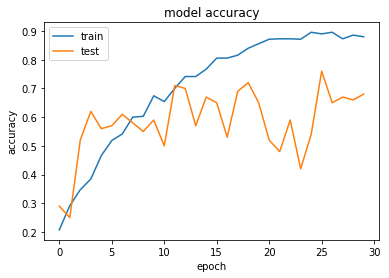

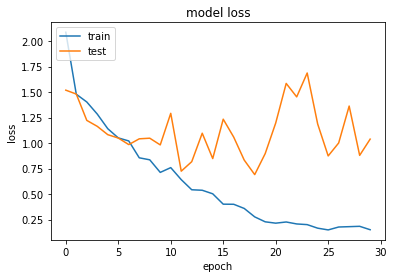

In [14]:
# Provide all the historical data
print(history.history.keys())

# summarize the history inorder to improve accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2. Learning in the Conv2D to be transferred in RNN GRU mode using TimeDistributed. Last layer to be transferred as softmax

In [24]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30  # batch size with the corresponding experiment
image_index = np.arange(0,30,1)
#image_index = np.random.randint(len(train_doc), size=batch_size)
x= len(image_index)
y=60
z=60

print('Batch Size: {0}, x: {1}, y: {2}, z: {3}, Image Index : {4}'.format(batch_size,x,y,z, image_index))

Batch Size: 30, x: 30, y: 60, z: 60, Image Index : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [25]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences amount =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences amount =', num_val_sequences)
num_epochs = 10 # select the amount of epochs
print ('# epochs =', num_epochs)

# training sequences amount = 663
# validation sequences amount = 100
# epochs = 10


In [26]:
#Kindly initialize shape to the Conv3D
input_shape = np.zeros((batch_size,x,y,z,3))

#Dense Parameter present 
num_classes=5

input_shape.shape[1:], nb_filters, nb_dense

((30, 60, 60, 3), [8, 16, 32, 64], [256, 128, 5])

In [27]:
# 23.521M parameters are transferred by ResNet50 
resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')

# Alone(self) training of the classifier
input_layer = Input(shape=input_shape.shape[1:])

#The Time Distributed layer
curr_layer = TimeDistributed(resnet)(input_layer)
curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 2048))(curr_layer)

# The GRU layer along with regularisation of Dropout 
gru_out = GRU(64, dropout=0.25)(curr_layer)

# The output layer
output = Dense(output_dim=num_classes, activation='softmax')(gru_out)
model = Model([input_layer], output)

#The Summary of Model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 60, 60, 3)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 2048)          23587712  
_________________________________________________________________
reshape_2 (Reshape)          (None, 30, 2048)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                405696    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 23,993,733
Trainable params: 23,940,613
Non-trainable params: 53,120
_________________________________________________________________


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5)`
  from ipykernel import kernelapp as app


## The Compilation and Selection of Model

### Foloowing are the Batch Size = 50, Frames = 30, Image Size 120 * 120, Epoch 10, Filter 3 * 3 * 3 working upon

In [28]:
optimiser = 'adam' #Specify the optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.001) # Specify the Rerducelronplateau code
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [32]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 30
Source path =  Epoch 1/10
./Project_data/train ; batch size = 30
23/23 [==============================] - 93s 4s/step - loss: 1.2101 - categorical_accuracy: 0.4870 - val_loss: 2.6181 - val_categorical_accuracy: 0.3583

Epoch 00001: saving model to model_init_2020-05-2212_20_20.858211/model-00001-1.21008-0.48696-2.61806-0.35833.h5
Epoch 2/10
23/23 [==============================] - 67s 3s/step - loss: 0.4536 - categorical_accuracy: 0.8101 - val_loss: 1.1973 - val_categorical_accuracy: 0.6167

Epoch 00002: saving model to model_init_2020-05-2212_20_20.858211/model-00002-0.45362-0.81014-1.19730-0.61667.h5
Epoch 3/10
23/23 [==============================] - 73s 3s/step - loss: 0.2951 - categorical_accuracy: 0.8957 - val_loss: 3.1707 - val_categorical_accuracy: 0.1583

Epoch 00003: saving model to model_init_2020-05-2212_20_20.858211/model-00003-0.29513-0.89565-3.17068-0.15833.h5
Epoch 4/10
23/23 [==============================] - 74s 3s/s

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


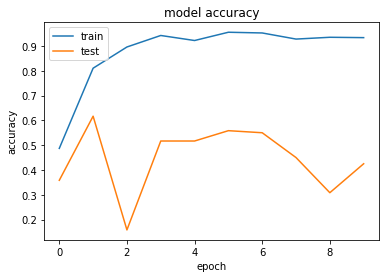

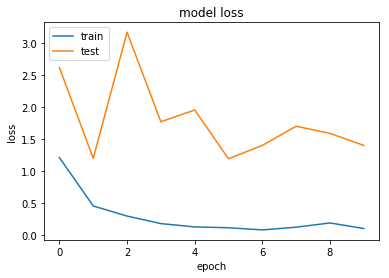

In [33]:
# Specify all the historical data
print(history.history.keys())

# Summarize the historical data to improve accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize the historical data for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()